In [1]:
#import libraries
from tqdm import tqdm
import argparse
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from models import *

In [2]:
# import necessary libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from utils import *
import warnings
warnings.filterwarnings('ignore')

In [4]:
#loading of data. 


file = np.load("../data/cube.npy", mmap_mode='r', fix_imports=True)
labels = np.load("../data/labels.npy", mmap_mode='r', fix_imports=True)

In [5]:
#Define the sample data

sample = 4367

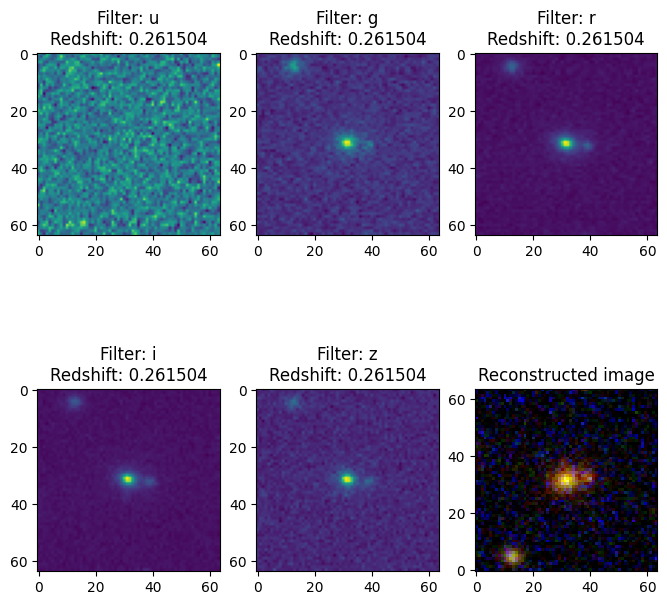

In [6]:
# Show a sample from the dataset. 
import img_scale

img_data = file[sample,:,:,:]

columns = 3
rows = 2
ax = []
fnames = ["u","g","r","i","z"]
fig = plt.figure(figsize=(8, 8))
for i in range(columns*rows):
    if i == 5:
        rgb_array = ugriz_to_rgb(img_data)
        ax.append( fig.add_subplot(rows, columns, i+1))
        ax[-1].set_title("Reconstructed image")
        plt.imshow(rgb_array, interpolation='nearest', origin='lower')
        break

    img = img_data[:,:,i]
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("Filter: "+str(fnames[i])+"\nRedshift: "+str(labels[sample][5]))
    plt.imshow(img)
plt.show()


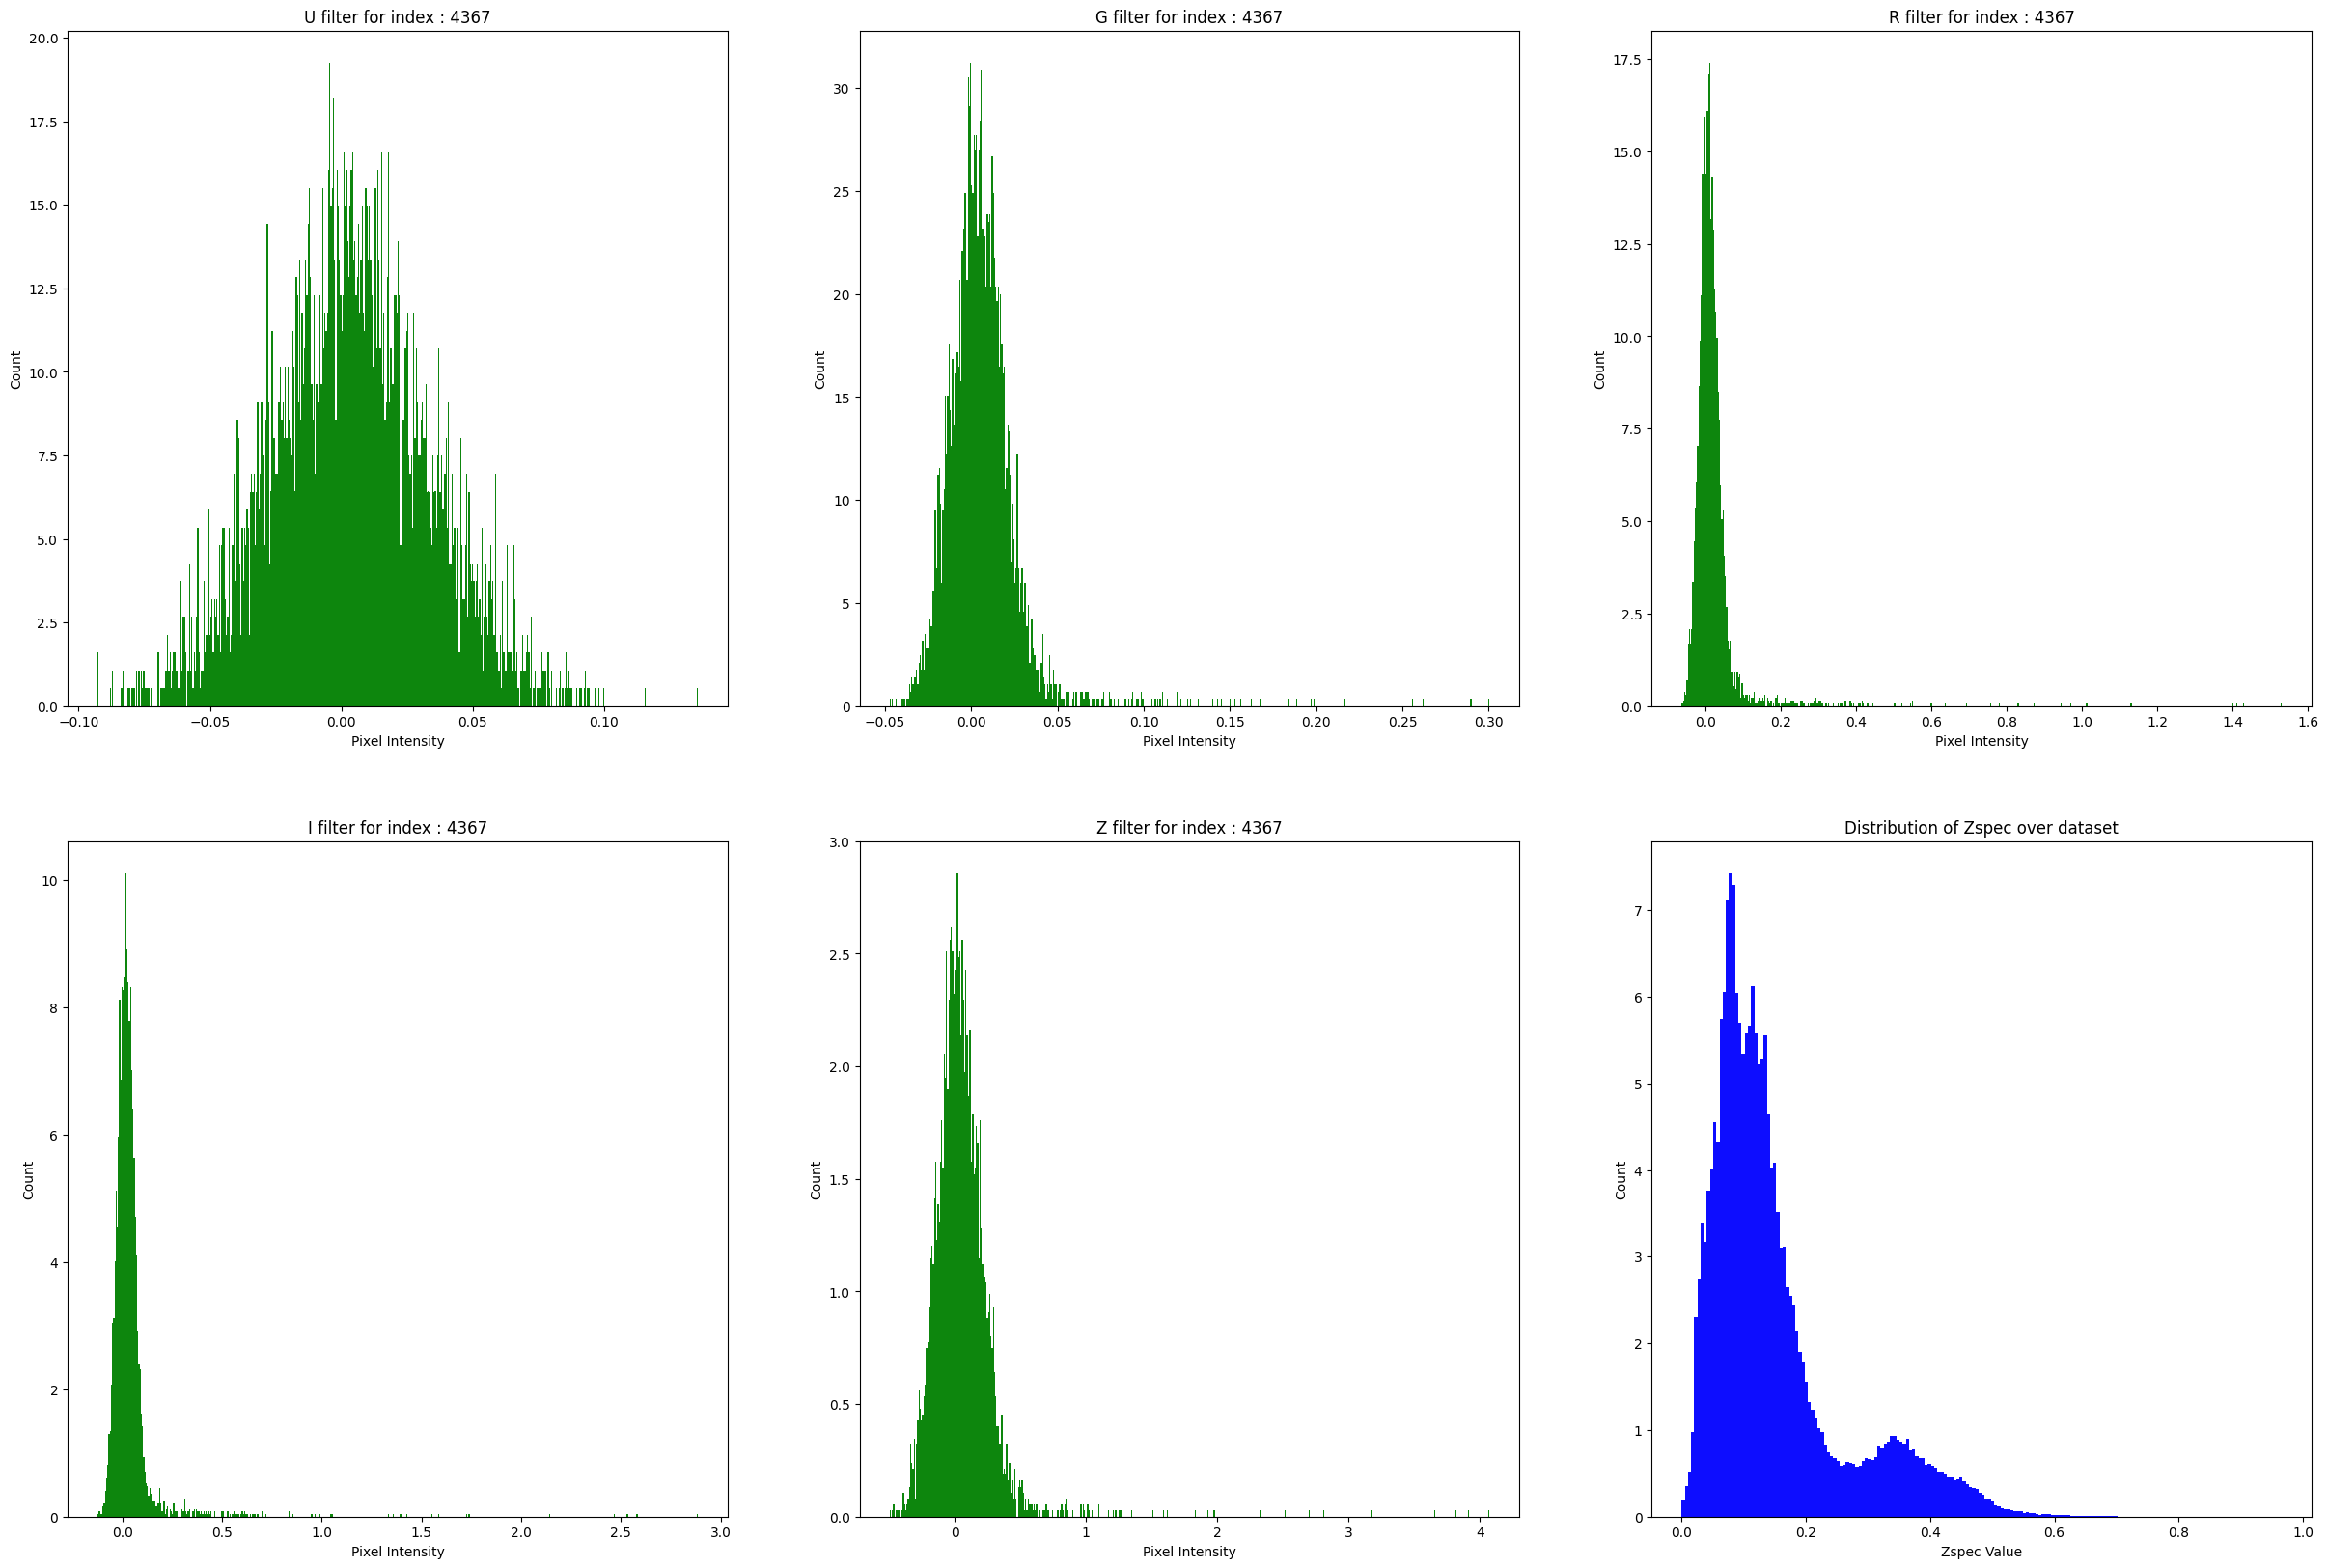

In [7]:
# Plot the histogram of each filter

datapt = [file[sample,:,:,j].reshape(-1) for j in range(5)]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))
filters = [f'{x} filter for index : {sample}' for x in ['U','G','R','I','Z']]
for i in range(5):
    x = datapt[i]
    ax[i-i%3-2,i%3].set_title(filters[i])
    ax[i-i%3-2,i%3].set_xlabel("Pixel Intensity")
    ax[i-i%3-2,i%3].set_ylabel("Count")
    ax[i-i%3-2,i%3].hist(x, 500, density=True, facecolor='g', alpha=0.95)

ax[1,2].set_title("Distribution of Zspec over dataset")
ax[1,2].set_xlabel("Zspec Value")
ax[1,2].set_ylabel("Count")
ax[1,2].hist([sample[5] for sample in labels],190,density=True, facecolor='b', alpha=0.95)
    
plt.show()

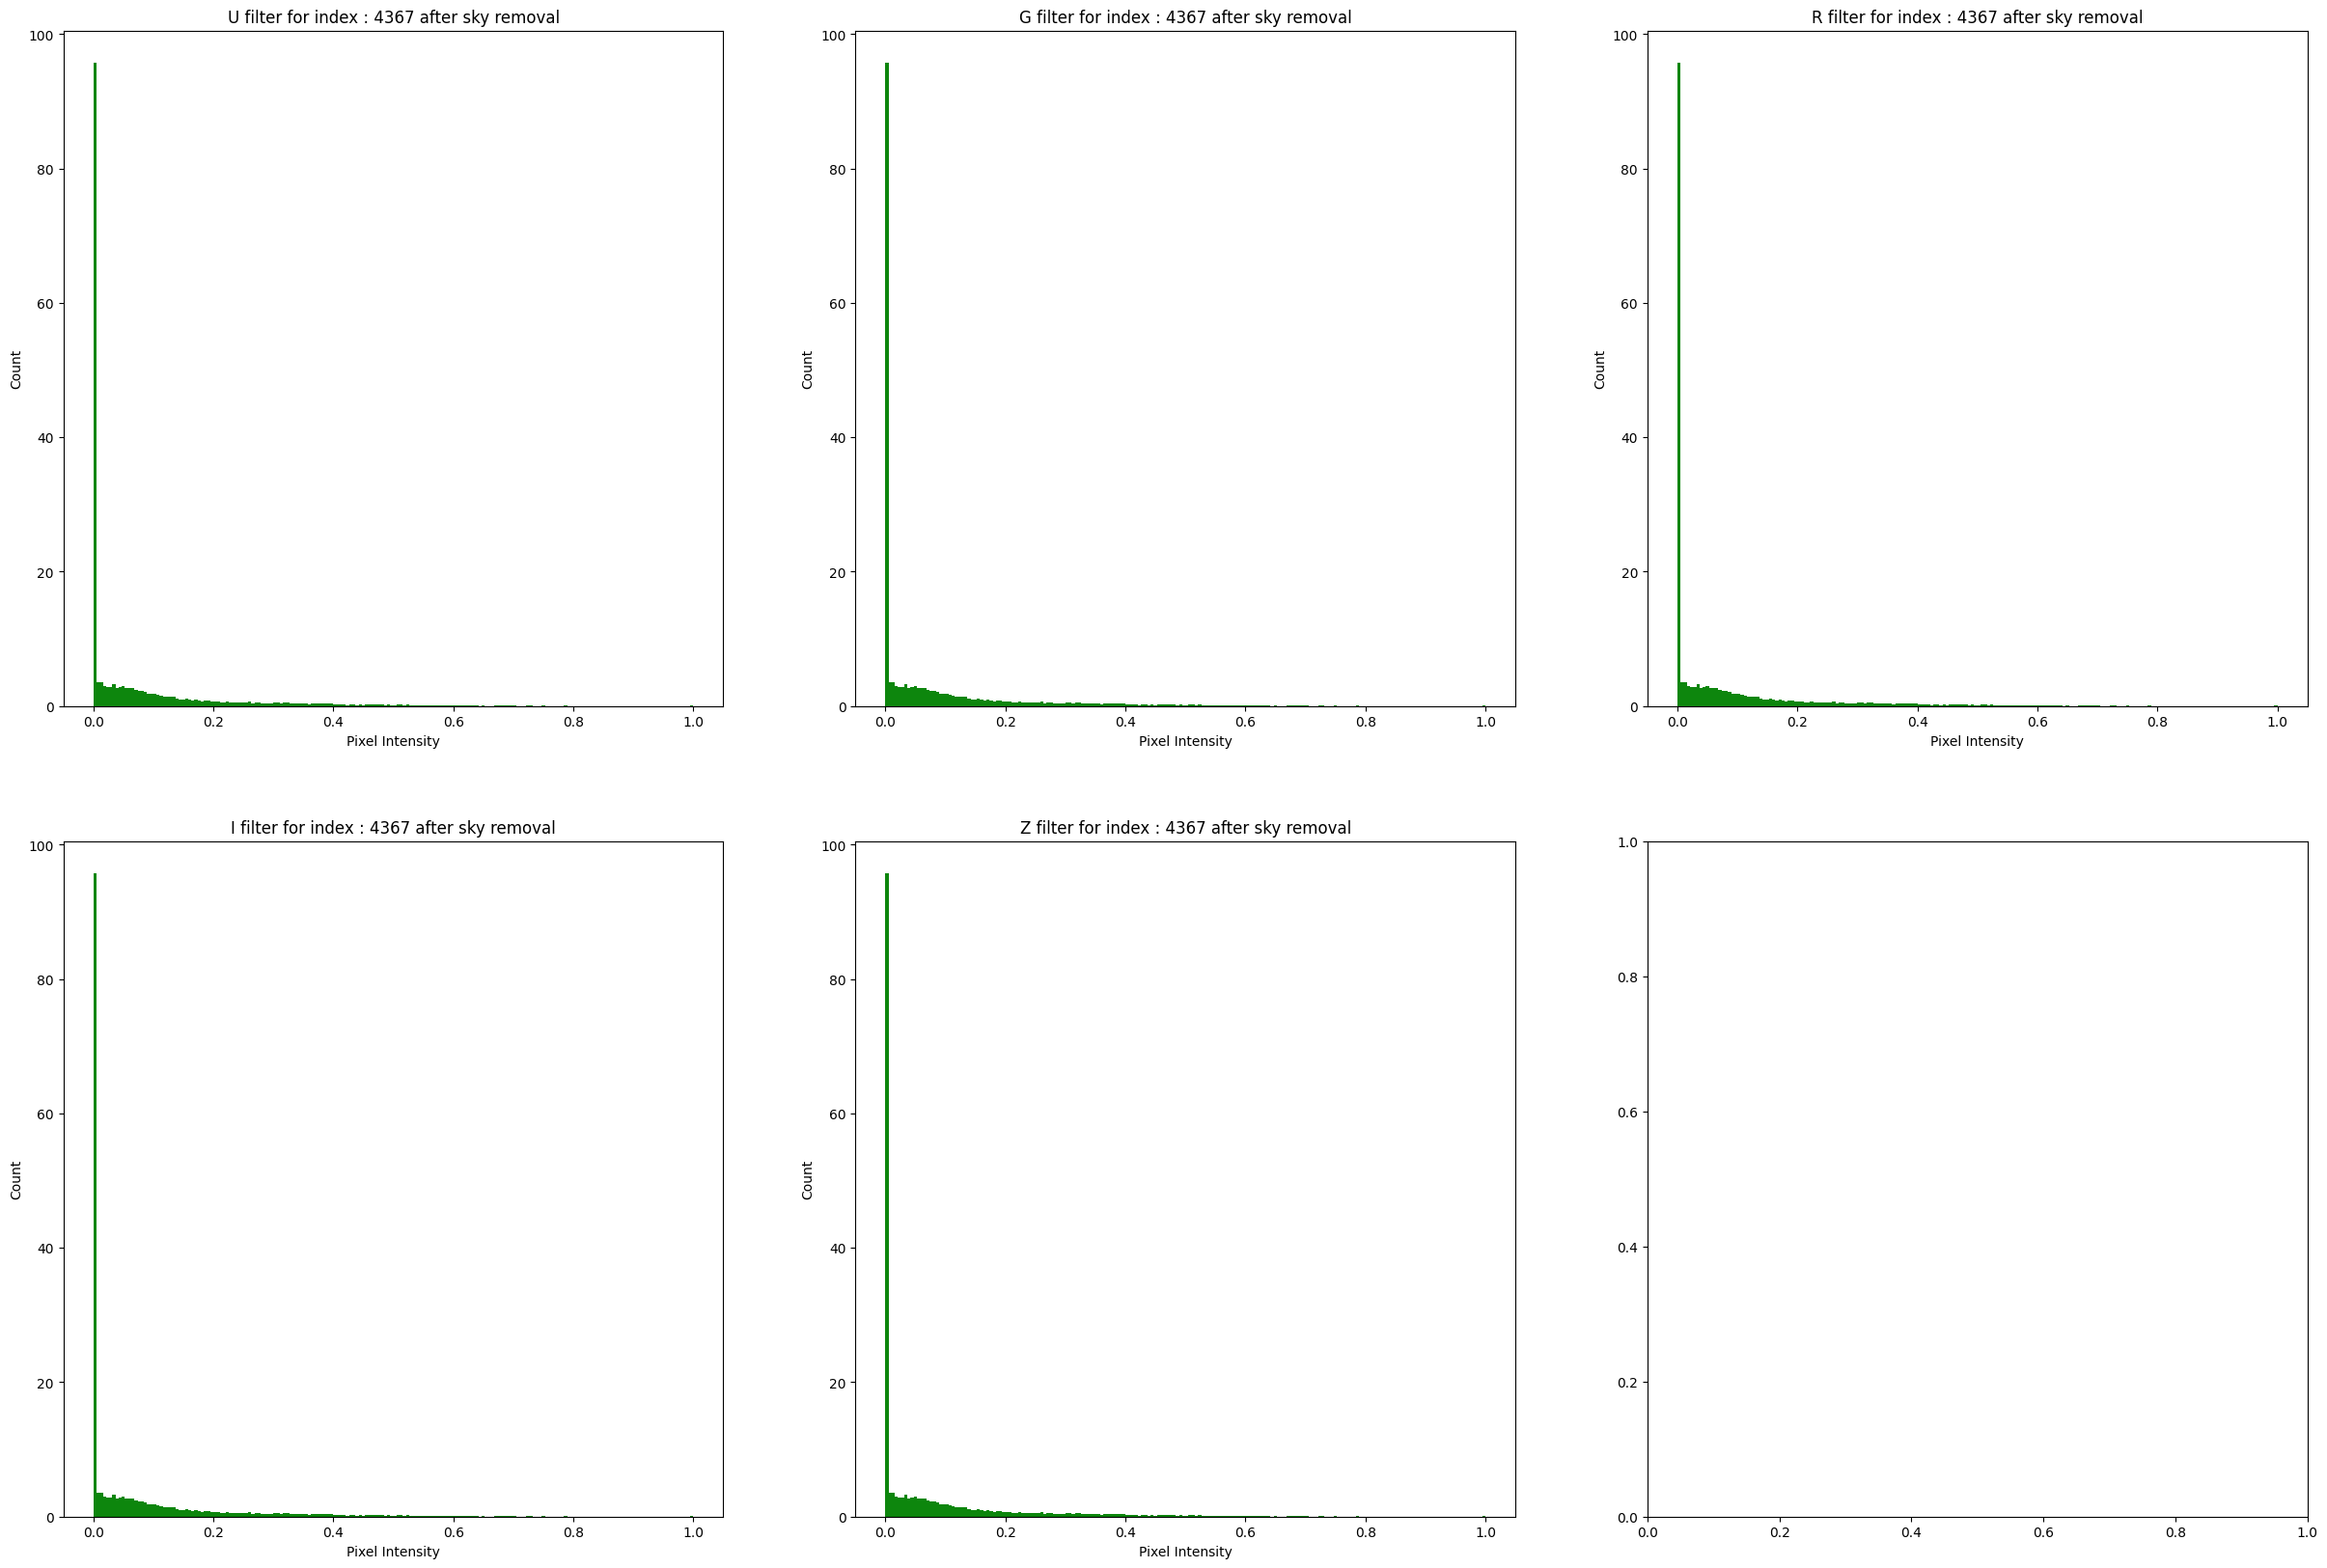

In [8]:
# Plot the histogram of each filter after sky correction. Notice all sky pixels are reduced to 0. 
# rest of the pixels magnitude are left as it is. 
sky_corrected_sample = sky_removal()(file[sample,:,:,:].copy())

datapt = [sky_corrected_sample.reshape(-1) for j in range(5)]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))
filters = [f'{x} filter for index : {sample} after sky removal' for x in ['U','G','R','I','Z']]
for i in range(5):
    x = datapt[i]
    ax[i-i%3-2,i%3].set_title(filters[i])
    ax[i-i%3-2,i%3].set_xlabel("Pixel Intensity")
    ax[i-i%3-2,i%3].set_ylabel("Count")
    ax[i-i%3-2,i%3].hist(x, 190, density=True, facecolor='g', alpha=0.95)

plt.show()

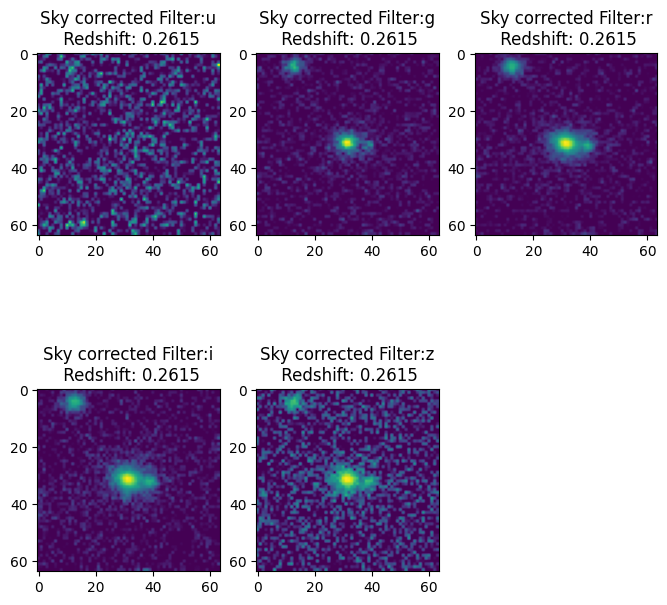

In [9]:
columns = 3
rows = 2
ax = []
fnames = ["u","g","r","i","z"]
fig = plt.figure(figsize=(8, 8))
for i in range(columns*rows):
    if i==5:
        break
    img = sky_corrected_sample[:,:,i]
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(f"Sky corrected Filter:{fnames[i]}\n Redshift: {labels[sample][5]:.4f}")
    plt.imshow(img)
plt.show()

In [10]:
# Change the model here and load appropriate checkpoint.
#model = A5([32,32],5,[2, 3, 5, 3, 5],[128, 128, 256, 256, 256],['T','C','T','C'])
#state_dict = torch.load('./logs/run14.pth')

model = A4()
state_dict = torch.load("./logs/run17.pth")

#model = A5([32,32],5,[1, 5, 5, 5, 5],[128, 128, 256, 256, 256],['C','C','T','T'])
#state_dict = torch.load("./logs/run24.pth")

model.load_state_dict(state_dict)
MM_input=True  # Ad-hoc parameter for mixed input models 
print(model)

A4(
  (cnn): Sequential(
    (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Inception_block(
      (branch0): Sequential(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): PReLU(num_parameters=1)
      )
      (branch1): Sequential(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): PReLU(num_parameters=1)
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): PReLU(num_parameters=1)
      )
      (branch2): Sequential(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): PReLU(num_parameters=1)
        (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): PReLU(num_parameters=1)
      )
      (branch3): Sequential(
        (0): AvgPool2d(kernel_size=1, stride=1, padding=0)
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(

In [11]:
# Visualise model. 

from torchviz import make_dot

x = torch.rand([1,5,32,32])
z = torch.rand([1,5])
y = model(x,z) if MM_input else model(x)
#make_dot(y.mean(), params=dict(model.named_parameters()))





In [12]:
# Create dataloader and run inference over whole dataset. 

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')
# Add sky_removal() before transforms.ToTensor() for sky correction. Note : computationally slow.
# ToDo: generate sky corrected dataset instead of doing it dynamically.
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(32),transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip()])
criterion = nn.MSELoss(reduction="sum")
dataset = MyDataset(file, labels, mm=MM_input, transform=transform)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=2,shuffle=True)

model.eval()
model.cuda()
metrics = [] #store the logs

if MM_input:
    # mixed input model loop 
    for i, data in enumerate(tqdm(dataset_loader)):
            inputs,extra,labels = data
            inputs,extra, labels = inputs.cuda(), extra.cuda(),labels.cuda()

            outputs = model(inputs,extra).squeeze() 
            loss = criterion(outputs, labels)  
            na = outputs.detach().to('cpu').numpy()
            nb = labels.detach().to('cpu').numpy()
            result = Metrics(na,nb)
            result["loss"] = loss.item()
            metrics.append(result)
    
else:
    # normal input model loop 
    for i,data in enumerate(tqdm(dataset_loader)):
        inputs,labels = data
        inputs,labels = inputs.cuda(),labels.cuda()
        outputs = model(inputs).squeeze() 
        loss = criterion(outputs, labels)
        na = outputs.detach().to('cpu').numpy()
        nb = labels.detach().to('cpu').numpy()
        result = Metrics(na,nb)
        result["loss"] = loss.item()
        metrics.append(result)


100%|█████████████████████████████████████| 10311/10311 [06:45<00:00, 25.40it/s]


The average MSE loss is 0.028235
The average MAE is 0.014329
The average NMAD is 0.013324
The average bias is -0.000982
The average outlier % is 1.452


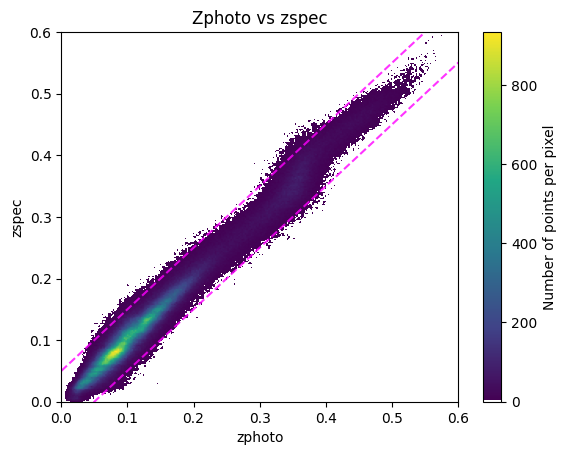

In [13]:
nmad = []
bias = []
MAE = []
loss = []
frac = []
z1 = []
z2 = []
for i,val in enumerate(metrics):
    nmad.append(val["nmad"])
    bias.append(val["bias"])
    MAE.append(val["MAE"])
    frac.append(val["frac"])
    loss.append(val['loss'])
    z1.extend(val["zspec"])
    z2.extend(val["zphoto"])

# Plot Metrics. 
avg = format_(metrics)
print(f"The average MSE loss is {avg[0]:.6f}")
print(f"The average MAE is {avg[1]:.6f}")
print(f"The average NMAD is {avg[2]:.6f}")
print(f"The average bias is {avg[3]:.6f}")
print(f"The average outlier % is {avg[4]:.3f}")

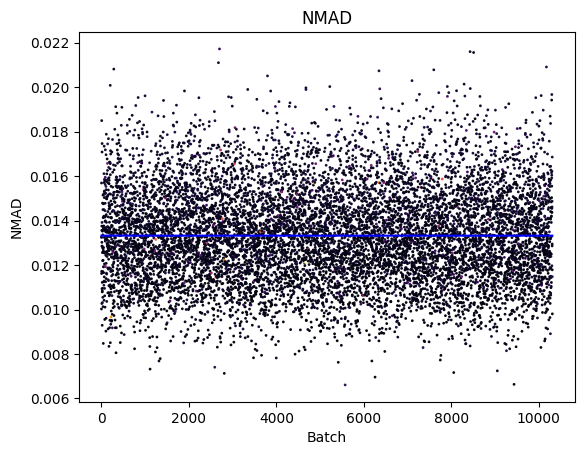

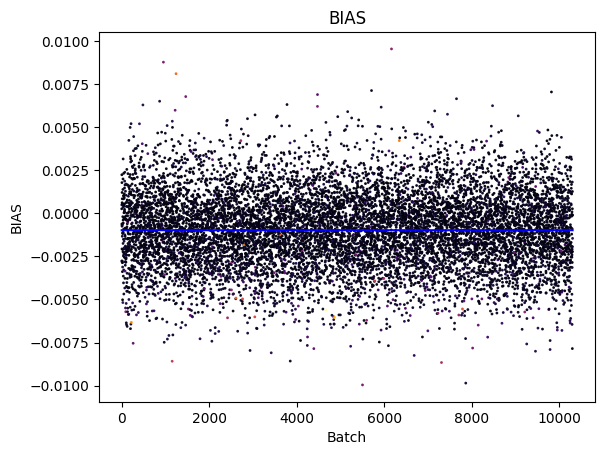

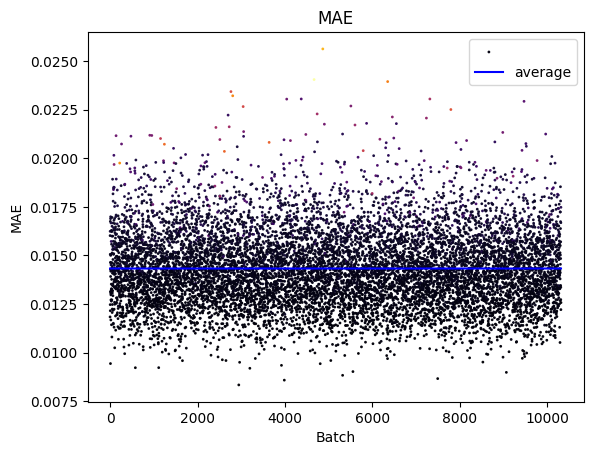

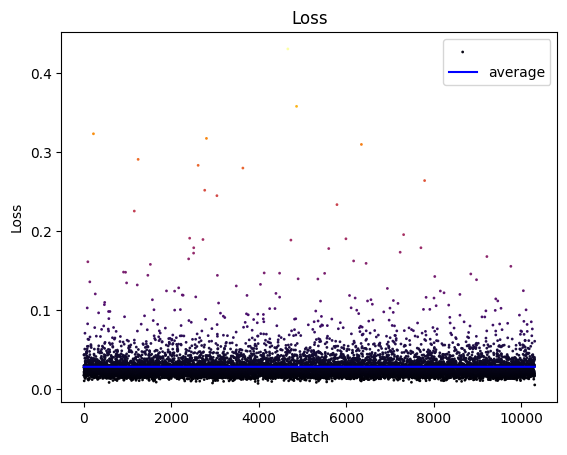

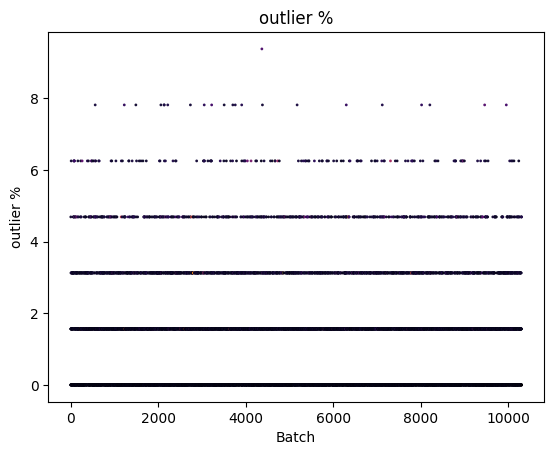

In [14]:
#Plot NMAD
haxis = [i for i in range(len(nmad))] 
plt.figure()
plt.title("NMAD")
plt.xlabel("Batch")
plt.ylabel("NMAD")
plt.scatter(haxis,nmad,c=loss,s=1,cmap="inferno", alpha=0.95) # size dependent on loss. 
plt.plot([avg[2] for _ in range(len(nmad))], 'b-')
#plt.legend(["", "average"])

#Plot BIAS
haxis = [i for i in range(len(bias))] 
plt.figure()
plt.title("BIAS")
plt.xlabel("Batch")
plt.ylabel("BIAS")
plt.scatter(haxis,bias,c=loss, s=1, cmap="inferno", alpha=0.95)
plt.plot([avg[3] for _ in range(len(nmad))], 'b-')
#plt.legend(["", "average"])


#Plot MAE
haxis = [i for i in range(len(MAE))] 
plt.figure()
plt.title("MAE")
plt.xlabel("Batch")
plt.ylabel("MAE")
plt.scatter(haxis,MAE,c=loss,s=1, cmap="inferno", alpha=0.95)
plt.plot([avg[1] for _ in range(len(nmad))], 'b-')
plt.legend(["", "average"])

#Plot Loss
haxis = [i for i in range(len(loss))] 
plt.figure()
plt.title("Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.scatter(haxis, loss,c=loss,s=1, cmap="inferno", alpha=0.95)
plt.plot([avg[0] for _ in range(len(nmad))], 'b-')
plt.legend(["", "average"])

#Plot Frac outiers 
haxis = [i for i in range(len(frac))] 
plt.figure()
plt.title("outlier %")
plt.xlabel("Batch")
plt.ylabel("outlier %")
plt.scatter(haxis,frac,c=loss,s=1, cmap="inferno", alpha=0.95)


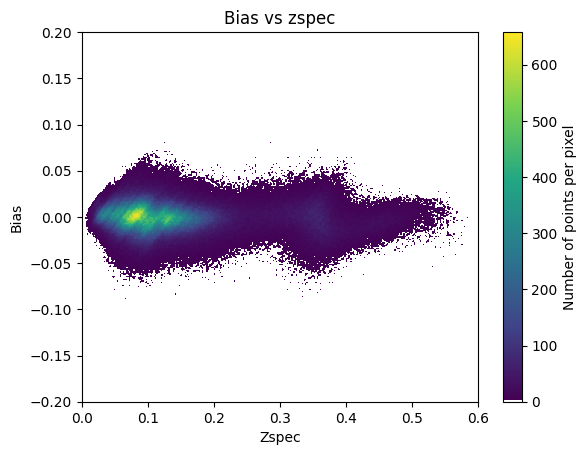

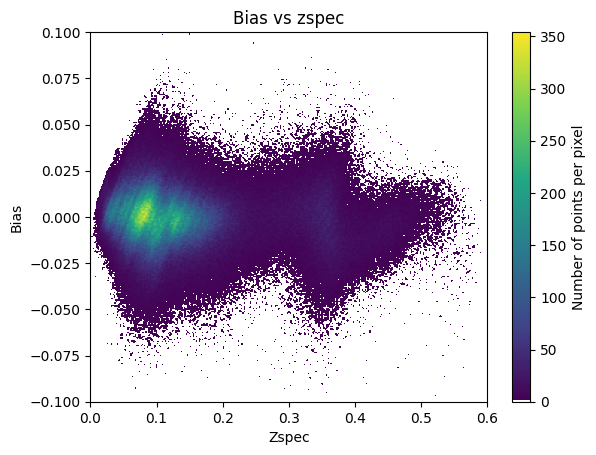

In [15]:
#Plot bias vs zspec 
bias_new = [(z1[i]-z2[i])/(1+z1[i]) for i in range(len(z1))]
#plt.figure()
#plt.title("bias vs Zspec")
#plt.xlabel("Zspec")
#plt.ylabel("bias")
#plt.xlim([0,0.63])
#plt.ylim([-0.4,0.4])
#plt.scatter(z1,bias_new,c=bias_new,cmap='gnuplot',s=0.3)

plot_bias_zspec(z1,bias_new)

#plt.figure()
#plt.title("bias vs Zspec (zoomed)")
#plt.xlabel("Zspec")
#plt.ylabel("bias")
#plt.xlim([0,0.63])
#plt.ylim([-0.2,0.2])
#plt.scatter(z1,bias_new,c=bias_new,cmap='gnuplot2',s=0.3)
plot_bias_zspec(z1,bias_new, zoom=True)


Text(0.5, 0, 'outlier %')

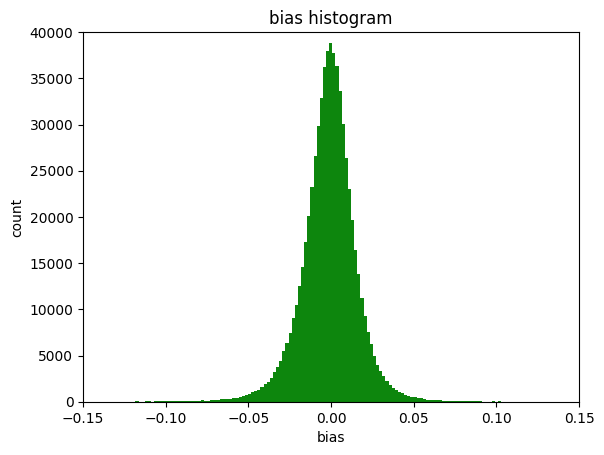

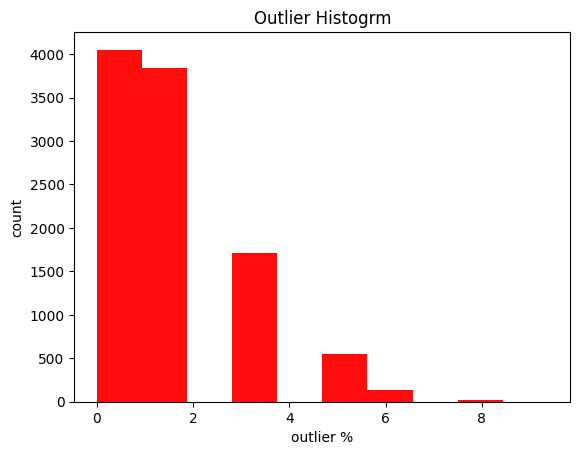

In [16]:
#Bias Histogram
plt.figure()
plt.hist(bias_new,500, facecolor='g', alpha=0.95)
plt.title("bias histogram")
plt.xlabel("bias")
plt.ylabel("count")
plt.xlim([-0.15,0.15])
plt.ylim([0,40000])

#Plot Frac histogram
plt.figure()
plt.hist(frac,10, facecolor='r', alpha=0.95)
plt.title("Outlier Histogrm")
plt.ylabel("count")
plt.xlabel("outlier %")

Module cnn.0 filters:


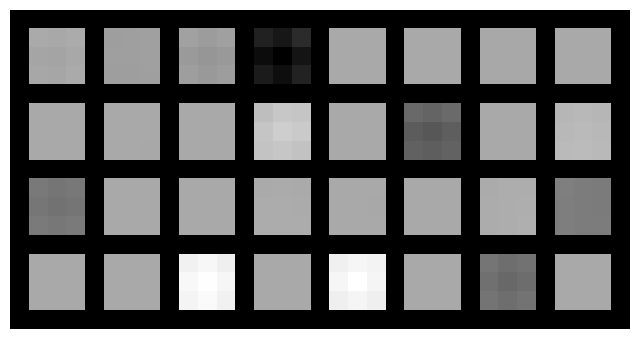

Module cnn.3.branch0.0 filters:


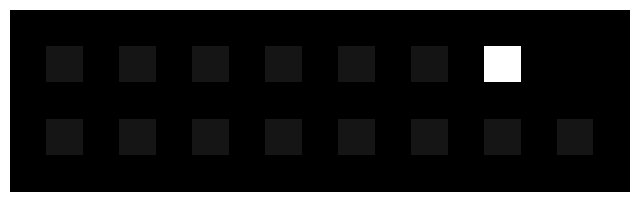

Module cnn.3.branch1.0 filters:


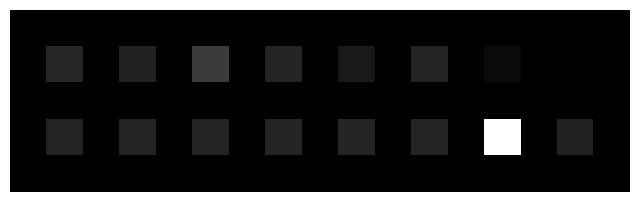

Module cnn.3.branch1.2 filters:


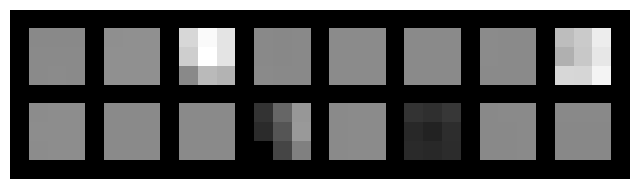

Module cnn.3.branch2.0 filters:


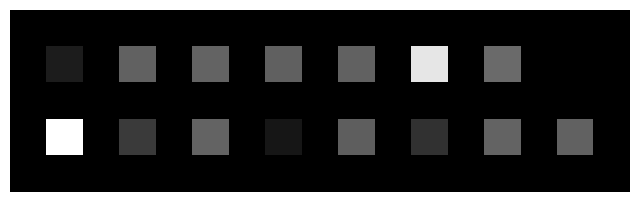

Module cnn.3.branch2.2 filters:


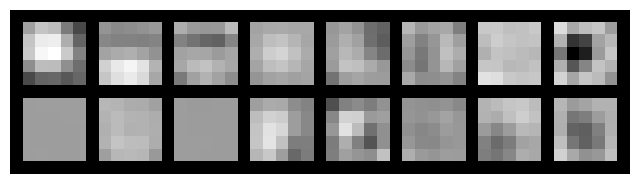

Module cnn.3.branch3.1 filters:


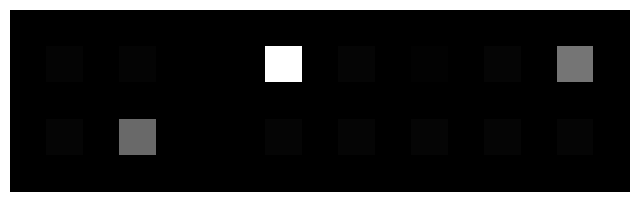

Module cnn.4.branch0.0 filters:


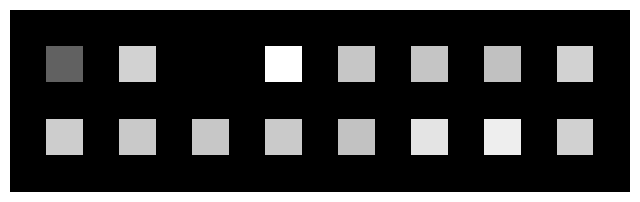

Module cnn.4.branch1.0 filters:


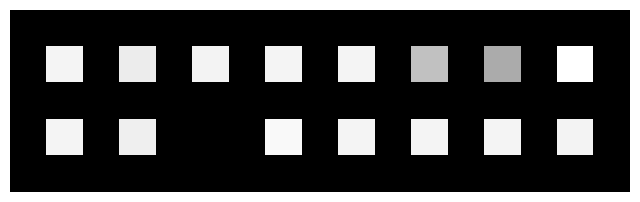

Module cnn.4.branch1.2 filters:


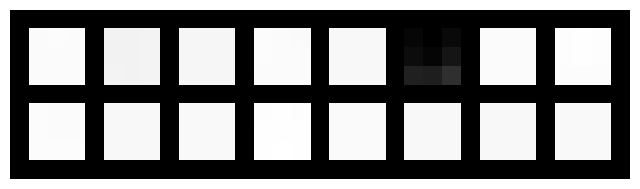

Module cnn.4.branch2.0 filters:


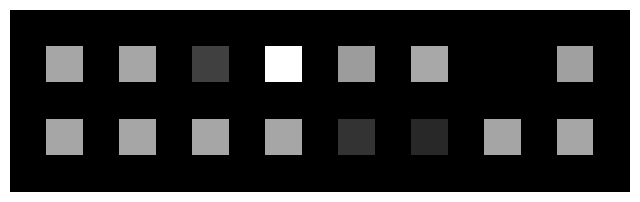

Module cnn.4.branch2.2 filters:


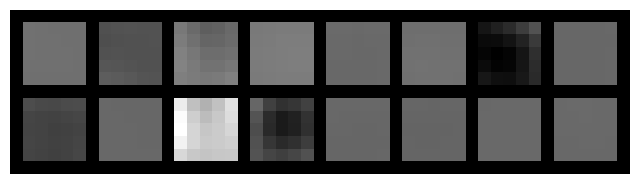

Module cnn.4.branch3.1 filters:


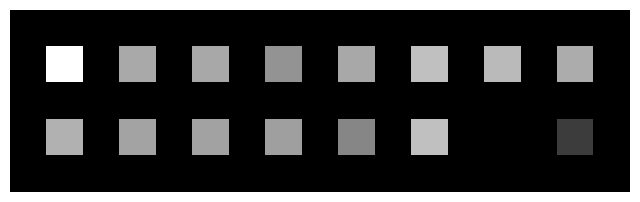

Module cnn.5.branch0.0 filters:


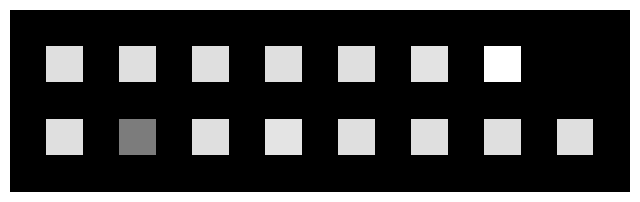

Module cnn.5.branch1.0 filters:


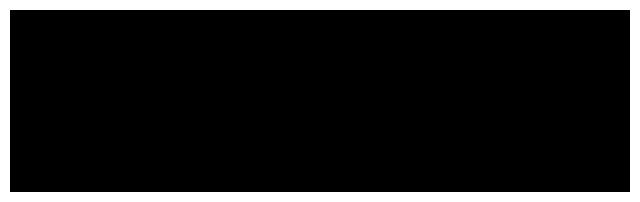

Module cnn.5.branch1.2 filters:


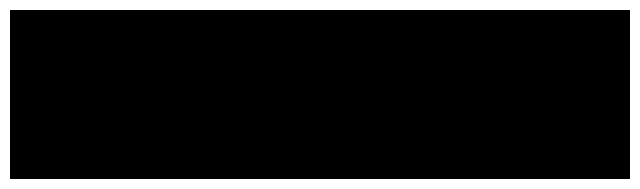

Module cnn.5.branch2.0 filters:


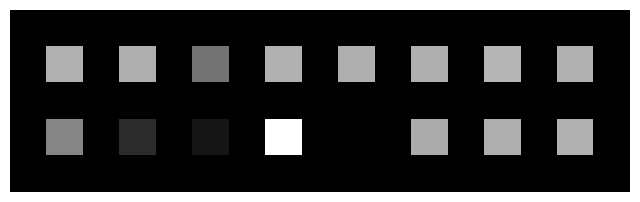

Module cnn.5.branch2.2 filters:


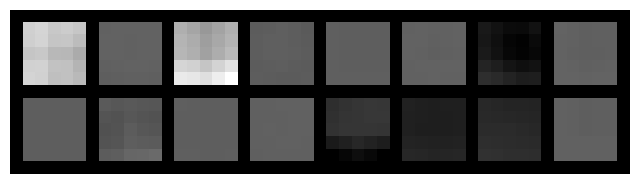

Module cnn.5.branch3.1 filters:


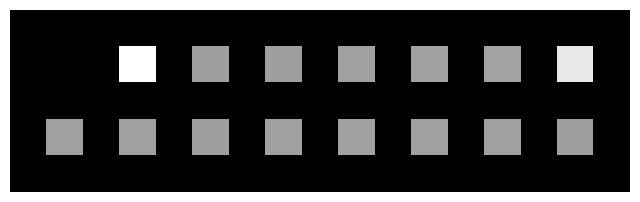

Module cnn.7.branch0.0 filters:


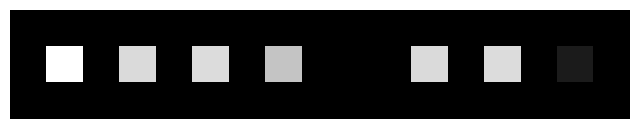

Module cnn.7.branch1.0 filters:


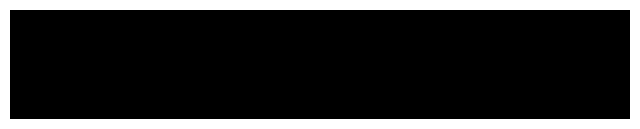

Module cnn.7.branch1.2 filters:


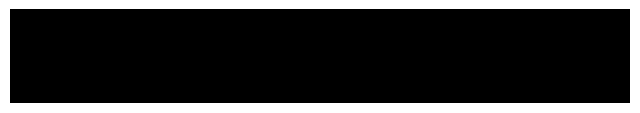

Module cnn.7.branch2.0 filters:


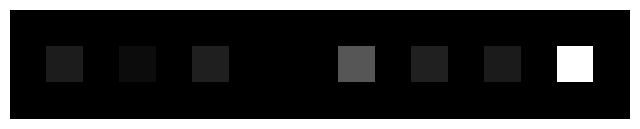

Module cnn.7.branch2.2 filters:


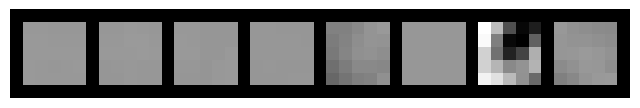

Module cnn.7.branch3.1 filters:


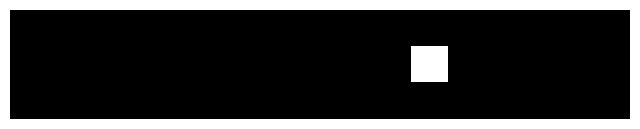

Module cnn.8.branch0.0 filters:


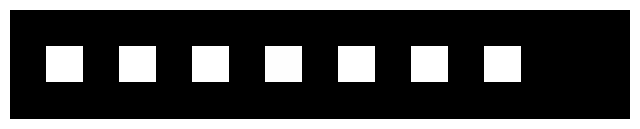

Module cnn.8.branch1.0 filters:


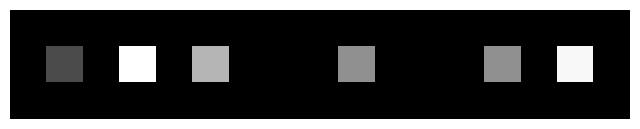

Module cnn.8.branch1.2 filters:


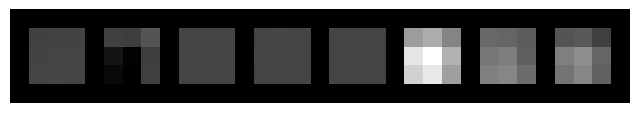

Module cnn.8.branch2.0 filters:


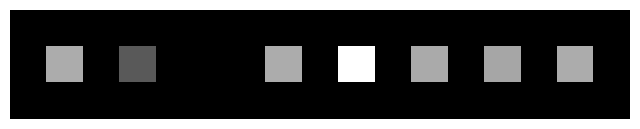

Module cnn.8.branch2.2 filters:


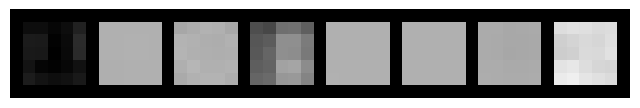

Module cnn.8.branch3.1 filters:


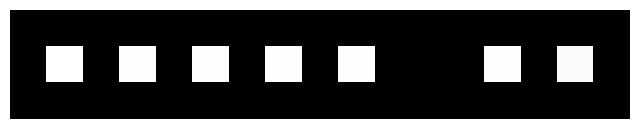

Module cnn.9.branch0.0 filters:


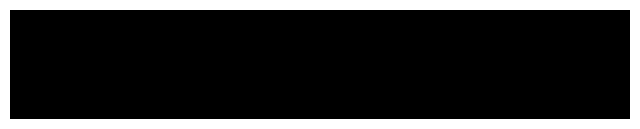

Module cnn.9.branch1.0 filters:


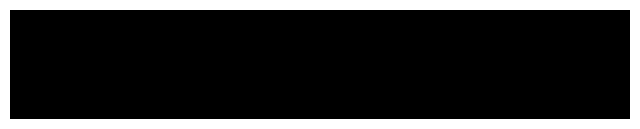

Module cnn.9.branch1.2 filters:


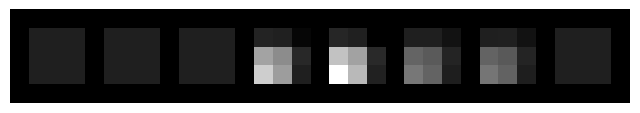

Module cnn.9.branch2.0 filters:


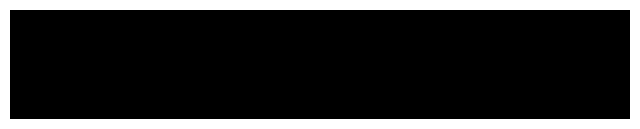

Module cnn.9.branch2.2 filters:


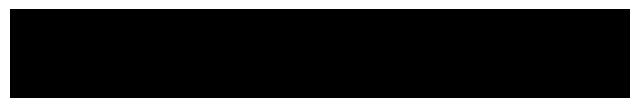

Module cnn.9.branch3.1 filters:


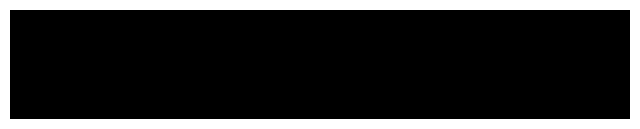

Module cnn.11.branch0.0 filters:


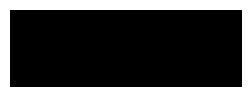

Module cnn.11.branch1.0 filters:


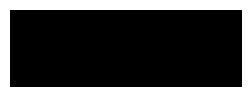

Module cnn.11.branch1.2 filters:


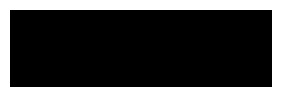

Module cnn.11.branch2.0 filters:


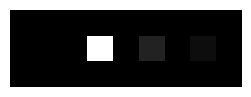

Module cnn.11.branch2.2 filters:


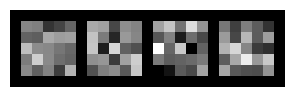

Module cnn.11.branch3.1 filters:


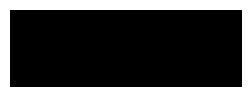

In [17]:
# Visualising Filters of CNN layers : 
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

l = [[name,module.weight.data.cpu()] for name,module in model.named_modules() if isinstance(module, nn.Conv2d)]
for i in range(len(l)):
    print(f"Module {l[i][0]} filters:")
    visTensor(l[i][1], ch=0, allkernels=False)
    plt.axis('off')
    plt.show()

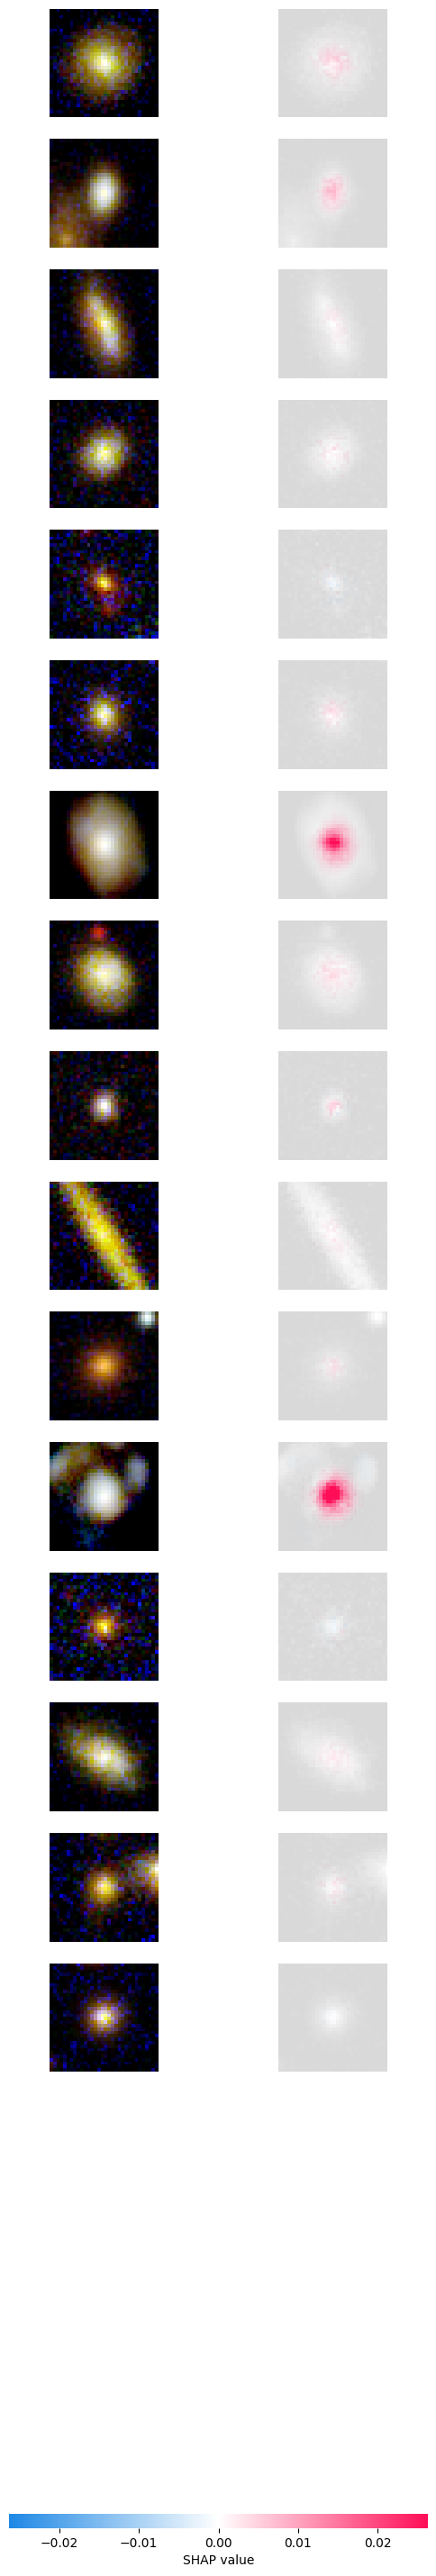

In [18]:
import shap

batch = next(iter(dataset_loader))

if MM_input:  #mixed input processing 
    images, extra,preds = batch
    background = images[:48]
    test_images = images[48:]
    extra1 = extra[:48]
    extra2 = extra[48:]
    e = shap.DeepExplainer(model.cpu(), [background,extra1])
    shap_values = e.shap_values([test_images,extra2])
    
else:
    images,preds = batch
    background = images[:48]
    test_images = images[48:]
    e = shap.DeepExplainer(model.cpu(), background)
    shap_values = e.shap_values(test_images)


shap_values[0] = rearrange(shap_values[0],"b c h w -> b h w c")

test_images = rearrange(test_images,"b c h w -> b h w c")
img_rgb_data = np.array([ugriz_to_rgb(s) for s in test_images.numpy()])
#img_rgb_data = rearrange(img_rgb_data,"b h w c -> b c h w")

shap.image_plot(-shap_values[0], img_rgb_data) # image shap analysis




In [19]:
# Saliency Map

def compute_saliency_maps(X, y, model):
    #freeze model gradients
    model.eval()
    
    # Make input tensor require gradient
    X[0].requires_grad_()  
    saliency = None

    #forward pass
    scores = model(X[0],X[1])
    y_temp = rearrange(y,"w -> w 1")
    scores.backward(y_temp) #compute gradients wrt. image pixels
    saliency, _ = torch.max(X[0].grad.data.abs(), dim=1)

    return saliency

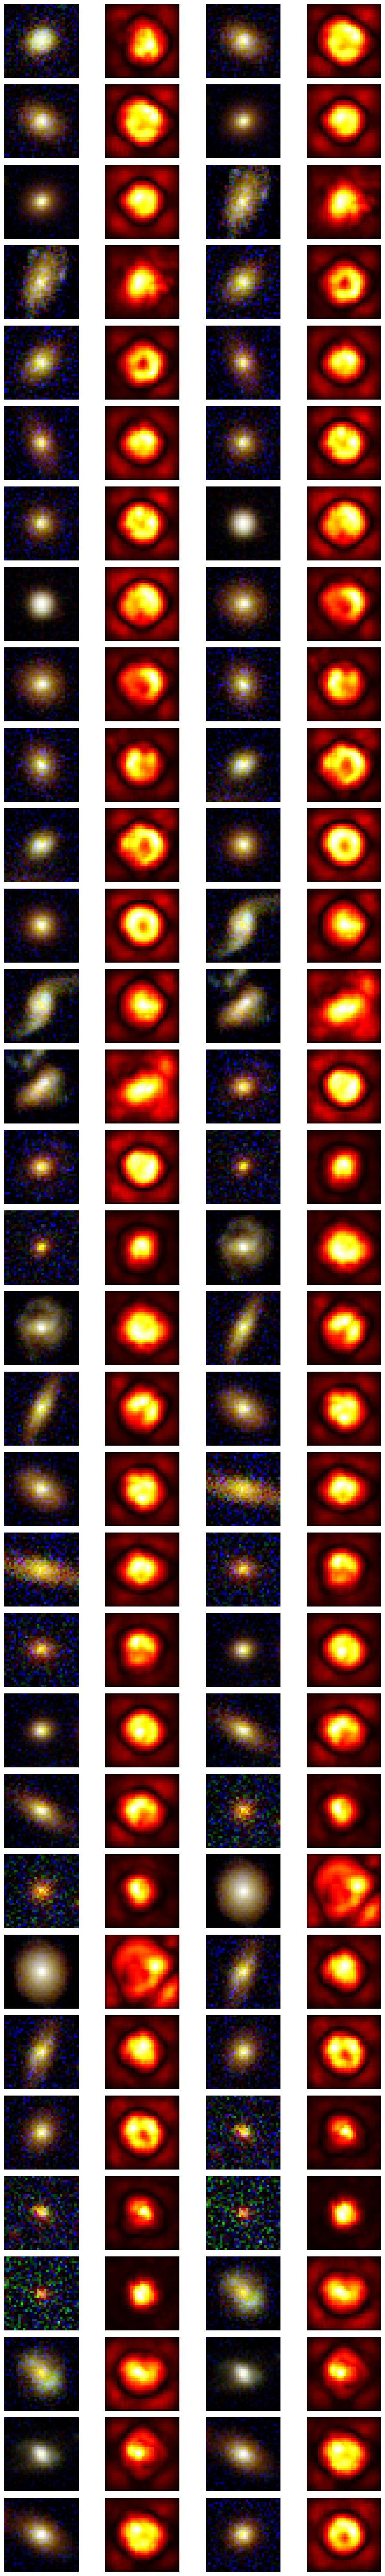

In [22]:
#Saliency Map.
data1,data2,pred = next(iter(dataset_loader))
data1 = data1[:]
data2 = data2[:]
data3 = rearrange(data1,"b c h w -> b h w c")
data4 = [ugriz_to_rgb(s) for s in data3.detach().numpy()]
smaps = compute_saliency_maps([data1,data2],pred,model)

#plt.imshow(smaps[15])
#plt.show()
#plt.imshow(data4[15])

#Plot the saliency map with image.
fig, ax = plt.subplots(nrows=len(data4)//2,ncols=4,figsize=(10,60))
count=0 # dummy variable for plotting function
for i in range(0,len(data4)//2):
    ax[i,0].imshow(data4[count])
    ax[i,0].axis('off')
    ax[i,1].imshow(smaps[count], cmap='hot')
    ax[i,1].axis('off')
    count += 1
    ax[i,2].imshow(data4[count])
    ax[i,2].axis('off')
    ax[i,3].imshow(smaps[count], cmap='hot')
    ax[i,3].axis('off')
plt.tight_layout()
plt.show()
